In [1]:
import os
import numpy as np
import pickle

In [2]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
mx.random.seed(1)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
root_path = os.getcwd()

## 1. Prepare Dataset

### 1.1 Build Self-defined Iterator

In [5]:
train_data = os.path.join(root_path, "omniglot", "train.pickle")
val_data = os.path.join(root_path, "omniglot", "val.pickle")

In [6]:
class Data_Loader:
    """
    batch: (batch_size, channel, height, width)
    """
    def __init__(self, path):
        self.data = {}
        self.chars = {}
        self.n_chars = {}
        self.h = 105
        self.w = 105
        self.n_images = 20
        with open(os.path.join(path,"train.pickle"),"r") as f:
            (tr_imgs, tr_char) = pickle.load(f)
            self.data['train'] = tr_imgs
            self.chars["train"] = tr_char
            self.n_chars["train"] = len(tr_char.keys())
            
        with open(os.path.join(path,"val.pickle"),"r") as f:
            (va_imgs, va_char) = pickle.load(f)
            self.data['val'] = va_imgs
            self.chars["val"] = va_char
            self.n_chars["val"] = len(va_char.keys())
                       
    def get_batch(self, batch_size, case="train"):
        """
        return #batch_size pairs and corresponding labels
        """
        cur_data = self.data[case]
        cur_chars = self.chars[case]        
        cur_labels = cur_chars.keys()
        
        img0 = mx.nd.empty([batch_size, 1, self.h, self.w])
        img1 = mx.nd.empty([batch_size, 1, self.h, self.w])
        tmp = mx.nd.uniform(low=0, high=1, shape=(batch_size,))        
        targets = mx.nd.rint(tmp)
        
        for i in range(batch_size):
            if targets[i].asscalar() != 1:
                # pairs are different chars
                labels = np.random.choice(cur_labels, size=2, replace=False)
                idxes = np.random.choice(self.n_images, size=2)
                img0[i, 0, :, :] = cur_data[labels[0]][idxes[0]].T
                img1[i, 0, :, :] = cur_data[labels[1]][idxes[1]].T               
            else:
                # pairs are from same char
                label = np.random.choice(cur_labels)
                idxes = np.random.choice(self.n_images, size=2, replace=False)
                img0[i, 0, :, :] = cur_data[label][idxes[0]].T
                img1[i, 0, :, :] = cur_data[label][idxes[1]].T
                
        return img0, img1, targets
    
    def get_test_batch(self, support_size, case="val", gt=None):
        """
        return pairs and corresponding labels
        batch: (support_size, 1, height, width)
        """
        cur_data = self.data[case]
        cur_chars = self.chars[case]        
        cur_labels = cur_chars.keys()
        
        img0 = mx.nd.empty([support_size, 1, self.h, self.w])
        img1 = mx.nd.empty([support_size, 1, self.h, self.w])
        targets = mx.nd.zeros((support_size,))
        
        labels = np.random.choice(cur_labels, size=support_size, replace=False)
        
        gt_idx = np.random.randint(support_size)
        true_label = labels[gt_idx]
        targets[gt_idx] = 1
        
        if gt:
            true_label = gt
            labels[gt_idx] = gt
        
        idxes = np.random.choice(self.n_images, size=support_size)
        for i in range(support_size):
            img0[i, 0, :, :] = cur_data[true_label][idxes[gt_idx]].T
            img1[i, 0, :, :] = cur_data[labels[i]][idxes[i]].T
                
        return img0, img1, targets        
        
    
    def evaluate_accuracy(self, net, eval_size, support_size, ctx, top_k=0, case="val"):
        """
        calculate accuracy over #eval_size test task, each task with a supporting set of #support_size
        """
        n_correct = 0
        n_correct_topk = 0
        
        for i in range(eval_size):
            img0, img1, targets = self.get_test_batch(support_size, case)
            img0 = img0.as_in_context(ctx)
            img1 = img1.as_in_context(ctx)
            targets = targets.as_in_context(ctx)
            
            score = net(img0, img1)
            
            targets_np = targets.asnumpy()
            score_np = score.asnumpy().flatten()
            true_idx = np.argmax(targets_np)
            pred_idx = np.argmax(score_np)
                                   
            
            if (targets[pred_idx]).asscalar() > 0:
                n_correct += 1
                n_correct_topk += 1
            else:                
                if top_k > 0:
                    topk_inds = np.argpartition(score_np, -top_k)[-top_k:]
                    if true_idx in topk_inds:
                        n_correct_topk += 1            
        
        acc = 100.0 * (n_correct*1.0 / eval_size)
        acc_topk = 100.0 * (n_correct_topk*1.0 / eval_size)
        return acc, acc_topk

In [7]:
pkl_path = os.path.join(root_path, "omniglot")
loader = Data_Loader(pkl_path)

In [9]:
# check one generated batch
img0, img1, targets = loader.get_batch(batch_size=4)
#img0, img1, targets = loader.get_test_batch(support_size=5)


[ 1.  0.  0.  1.]
<NDArray 4 @cpu(0)>


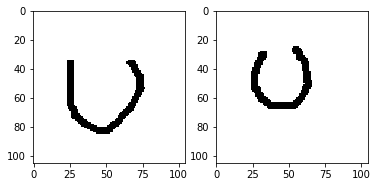

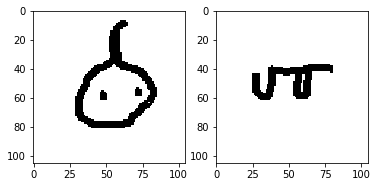

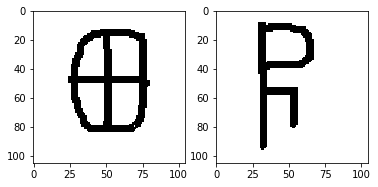

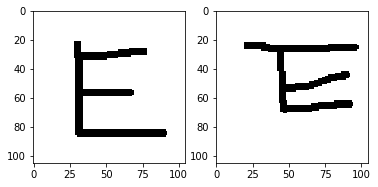

In [10]:
print(targets)
for j in range(4):
    plt.subplot(1,2,1)
    plt.imshow(img0[j,0,:,:].T.asnumpy(), cmap='gray'); 
    plt.subplot(1,2,2)
    plt.imshow(img1[j,0,:,:].T.asnumpy(), cmap='gray'); 
    plt.show()

## 2. Build Network

In [8]:
input_shape = (105, 105, 1)
num_fc = 4096
num_outputs = 1

In [9]:
class Siamese(gluon.Block):
    def __init__(self, **kwargs):
        super(Siamese, self).__init__(**kwargs)
        # use name_scope to give child Blocks appropriate names.
        # It also allows sharing Parameters between Blocks recursively.
        with self.name_scope():
            self.wing = gluon.nn.Sequential()
            with self.wing.name_scope():
                self.wing.add(gluon.nn.Conv2D(channels=64, kernel_size=10, activation='relu'))
                self.wing.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
                self.wing.add(gluon.nn.Conv2D(channels=128, kernel_size=7, activation='relu'))
                self.wing.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
                self.wing.add(gluon.nn.Conv2D(channels=128, kernel_size=4, activation='relu'))
                self.wing.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
                self.wing.add(gluon.nn.Conv2D(channels=256, kernel_size=4, activation='relu'))
                # The Flatten layer collapses all axis, except the first one, into one axis.
                self.wing.add(gluon.nn.Flatten())
                self.wing.add(gluon.nn.Dense(4096, activation="sigmoid"))
            
            self.fc = gluon.nn.Dense(1, activation="sigmoid")

    def forward(self, input0, input1):
        out0 = self.wing(input0)
        out1 = self.wing(input1)
        dist = mx.ndarray.abs(out0 - out1)
        score = self.fc(dist)
        return score

In [10]:
def count_params(params):
    cnt = 0
    for k in params.keys():
        cur_size = params[k].shape
        cur_cnt = reduce(lambda x,y: x*y, cur_size)
        print("Params: {}: {}".format(k, cur_cnt))
        cnt += cur_cnt
    return cnt

## 3. Define Loss
### Regularized Cross-Entropy

\begin{equation}
L(x_1, x_2, t) = t* \log({\bf{p}} (x_1,x_2)) + (1-t)* \log(1-{\bf{p}}(x_1,x_2)) + \lambda \|w \|_2
\end{equation}

In [11]:
ce_loss = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)

## 4. Training

In [12]:
ctx = mx.gpu()
n_iters = 10
batch_size = 16

eval_size = 500
support_size = 16
top_k = 3

from_scratch = True
model_path = os.path.join(root_path, "siamese_checkpoints")

In [13]:
net = Siamese()

In [14]:
if from_scratch: 
    net.collect_params().initialize(mx.init.Xavier(),ctx=ctx)
else:
    ckpt_name = os.path.join(model_path, "siamese_net_80.params")
    net.load_params(ckpt_name, ctx=ctx)

In [16]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0003, 'wd': 0.001})

In [17]:
loss_every = 5
eval_every = 5000
cnt = 0
best = 99

loss_train = []
acc_eval = []
acc_topk_eval = []

for i in range(n_iters):
    img0, img1, targets = loader.get_batch(batch_size=batch_size) 
    img0 = img0.as_in_context(ctx)
    img1 = img1.as_in_context(ctx)
    targets = targets.as_in_context(ctx)
    with autograd.record():
        preds = net(img0, img1)
        loss = ce_loss(preds, targets)        
    loss.backward()          
    trainer.step(batch_size)
    
    tr_loss = nd.mean(loss).asscalar()
    loss_train.append(tr_loss)
    
    if i % loss_every == 0:
        print("iteration {}, training loss: {:.4f},".format(i, tr_loss))
        
    if i % eval_every == 0:
        val_acc, val_acc_topk = loader.evaluate_accuracy(net,eval_size, support_size, ctx, top_k=top_k)
        print("iteration {}, top-1 accuracy: {:.4f}%, top-{} accuracy: {:.4f}%".format(i, val_acc, top_k, val_acc_topk))
        acc_eval.append(val_acc)
        acc_topk_eval.append(val_acc_topk)
        cnt += 1
        if val_acc >= best:            
            print("saving model ---------->")
            best=val_acc
            save_name = "siamese_net_" + str(cnt) + ".params"
            file_path = os.path.join(model_path, save_name)
            net.save_params(file_path)
            break

iteration 0, training loss: 0.6743,
iteration 0, top-1 accuracy: 14.6000%, top-3 accuracy: 44.8000%
iteration 5, training loss: 0.8142,


In [18]:
params = net.collect_params()
count_params(params)

Params: siamese0_sequential0_conv0_weight: 6400
Params: siamese0_sequential0_conv0_bias: 64
Params: siamese0_sequential0_conv1_weight: 401408
Params: siamese0_sequential0_conv1_bias: 128
Params: siamese0_sequential0_conv2_weight: 262144
Params: siamese0_sequential0_conv2_bias: 128
Params: siamese0_sequential0_conv3_weight: 524288
Params: siamese0_sequential0_conv3_bias: 256
Params: siamese0_sequential0_dense0_weight: 37748736
Params: siamese0_sequential0_dense0_bias: 4096
Params: siamese0_dense0_weight: 4096
Params: siamese0_dense0_bias: 1


38951745L

## 5. Sample Test

In [18]:
img0, img1, targets = loader.get_test_batch(support_size)
img0 = img0.as_in_context(ctx)
img1 = img1.as_in_context(ctx)
targets = targets.as_in_context(ctx)

In [19]:
score = net(img0, img1)

In [20]:
targets_np = targets.asnumpy()
score_np = score.asnumpy().flatten()

In [24]:
pred_idx = np.argmax(score_np)
topk_inds = np.argpartition(score_np, -3)[-3:]
preds = np.zeros(support_size,)
preds[pred_idx] = 1

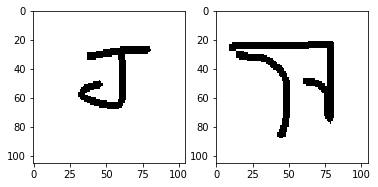

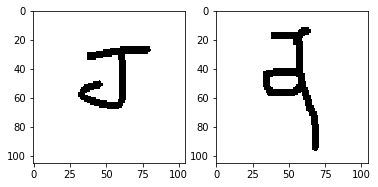

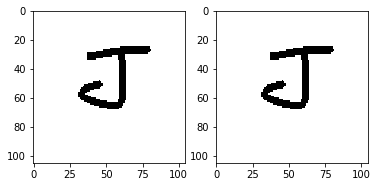

In [26]:
# plot the characters which has scores in top-3
for j in range(3):
    plt.subplot(1,2,1)
    plt.imshow(img0[topk_inds[j],0,:,:].T.asnumpy(), cmap='gray'); 
    plt.subplot(1,2,2)
    plt.imshow(img1[topk_inds[j],0,:,:].T.asnumpy(), cmap='gray'); 
    plt.show()

In [21]:
targets_np

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.], dtype=float32)

In [25]:
preds

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.])